Spooky Author Identification
=============

Deep Learning
------------

This notebook will be used to apply deep learning methods to predict the author. 

As what we have done in Notebook 2, we are still going to train separate deep learning models to predict the probabilities for each sentence, and then add the probabilities as new features for test set, and then train XGBoost model on these stacked features to predict the authors.

In [2]:
# All the modules that will be used later
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection, metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, GlobalAveragePooling1D
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
import xgboost as xgb
import itertools

np.random.seed(1001) # so that the result could be reproduced

Read the train and test sets which include the sentence statistics and text features created in Notebook 1 & 2.

In [3]:
train = pd.read_csv('train_features.csv')
test = pd.read_csv('test_features.csv')
# Drop the first unnamed column
train = train.drop('Unnamed: 0', axis = 1)
test = test.drop('Unnamed: 0', axis = 1)
print('Train data size: ', train.shape)
print('Test data size: ', test.shape)

Train data size:  (19579, 225)
Test data size:  (8392, 224)


In [4]:
# Class labels
author_mapping = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_label = train['author'].map(author_mapping)
y_label.shape

(19579,)

Convoluntional Neural Network & Recurrent Neural Network
--------------

As the vocabulary is very large, we can introduce an embedding lookup on the inputs, and feed the embeddings to the neural network instead of the inputs themselves. We will train a 1D CNN and LSTM.

Before feeding data into the neural networks, let's first process the text by the following steps:

- Separate punctuations from words
- Remove rare words which appear only once
- Cut long sentence which contains more than 100 words

In Notebook 1, we found that most sentences are shorter than 100 words. Thus we will use 100 as the maximum sequence length for padding here. This is a hyperparameter which could be tuned.

In [5]:
# Separate punctuations from words
def sep_punctuation(text):
    text = text.replace("' ", " ' ")
    punc = set(',.:;"?!')
    res = set(text) & punc # check whether there is punctuation in the text
    if not res:
        return text
    for p in res:
        text = text.replace(p, ' {} '.format(p))
    return text

In [6]:
train_text = []
test_text = []

for text in train['text'].values.tolist():
    tokens = sep_punctuation(text).split()
    train_text.append(' '.join(tokens))
    
for text in test['text'].values.tolist():
    tokens = sep_punctuation(text).split()
    test_text.append(' '.join(tokens))

all_text = train_text + test_text

In [7]:
# Tokenize each sentence into a sequence
tokenizer = Tokenizer(filters = '') # Treat punctuations as words
tokenizer.fit_on_texts(all_text)
num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= 2]) # remove rare words

tokenizer = Tokenizer(num_words = num_words, filters = '')
tokenizer.fit_on_texts(all_text)
train_text = tokenizer.texts_to_sequences(train_text)
test_text = tokenizer.texts_to_sequences(test_text)

print('Number of unique words: ', num_words)

Number of unique words:  18831


In [8]:
max_len = 100

train_text = pad_sequences(train_text, maxlen = max_len)
test_text = pad_sequences(test_text, maxlen = max_len)

Then let's fit a 1D convolutional neural network on the sequences we just created. 

In [9]:
# Architecture of 1D convolutional neural network
def conv_nn(num_words, max_len):
    model = Sequential()
    # Word embeddings, using a dimensionality of 100
    model.add(Embedding(num_words, 100, input_length = max_len))
    # Convolutional layer (1D, as temporal convolution)
    model.add(Conv1D(64, 5, padding = 'valid', activation = 'relu'))
    # Pooling layer
    model.add(MaxPooling1D())
    # Flatten layer
    model.add(Flatten())
    # Full connection layer
    model.add(Dense(128, activation = 'relu'))
    # Ouput layer
    model.add(Dense(3, activation = 'softmax'))
    # Compile the model
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
    return model 

In [11]:
# Convert the class labels to binary class matrix
y = np_utils.to_categorical(y_label)

# Stop training when there is no improvement in validation set loss
earlyStopping = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

# Run a 10-fold cross-validation using the sequences
log_loss = []
train_pred = np.zeros([train_text.shape[0], 3])
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for dev_idx, val_idx in kf.split(train):
    X_dev, X_val = train_text[dev_idx], train_text[val_idx]
    y_dev, y_val = y[dev_idx], y[val_idx]
    model = conv_nn(num_words, max_len)
    model.fit(x = X_dev, y = y_dev, batch_size = 32, epochs = 10, verbose = 0, 
              validation_data = (X_val, y_val), callbacks = [earlyStopping])
    y_pred = model.predict(X_val)
    log_loss.append(metrics.log_loss(y_val, y_pred))
    train_pred[val_idx] = y_pred # The predicted probabilities for validation set 

print("Mean cross-validation log-loss", np.mean(log_loss))

Mean cross-validation log-loss 0.440475926331


The log-loss is 0.44, very close to what we achieved by using term frequencies in Notebook 2. Let's plot the confusion matrix.

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[667  54  61]
 [ 67 454  45]
 [ 95  12 502]]


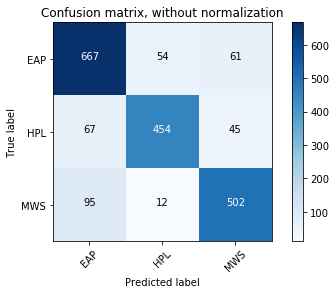

In [13]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_label[val_idx], np.argmax(y_pred, axis = 1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')

plt.show()

Let's add the predicted probabilities to train/test set.

In [15]:
# Add the probabilities to features of train set
train['conv_EAP'] = train_pred[:, 0]
train['conv_HPL'] = train_pred[:, 1]
train['conv_MWS'] = train_pred[:, 2]

In [14]:
model = conv_nn(num_words, max_len)
model.fit(x = train_text, y = y, batch_size = 32, epochs = 10, verbose = 0)
test_pred = model.predict(test_text)

# Add the probabilities to features of test set
test['conv_EAP'] = test_pred[:, 0]
test['conv_HPL'] = test_pred[:, 1]
test['conv_MWS'] = test_pred[:, 2]

Now let's try to fit RNN using LSTM on the sequences.

In [16]:
# Architecture of recurrent neural network using LSTM
def lstm_nn(num_words, max_len):
    model = Sequential()
    # Word embeddings, using a dimensionality of 100
    model.add(Embedding(num_words, 100, input_length = max_len))
    # LSTM layer with 5 memory units
    model.add(LSTM(5))
    # Ouput layer
    model.add(Dense(3, activation = 'softmax'))
    # Compile the model
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
    return model

In [17]:
# Run a 10-fold cross-validation using the sequences
log_loss = []
train_pred = np.zeros([train_text.shape[0], 3])
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for dev_idx, val_idx in kf.split(train):
    X_dev, X_val = train_text[dev_idx], train_text[val_idx]
    y_dev, y_val = y[dev_idx], y[val_idx]
    model = lstm_nn(num_words, max_len)
    model.fit(x = X_dev, y = y_dev, batch_size = 32, epochs = 10, verbose = 0, 
              validation_data = (X_val, y_val), callbacks = [earlyStopping])
    y_pred = model.predict(X_val)
    log_loss.append(metrics.log_loss(y_val, y_pred))
    train_pred[val_idx] = y_pred # The predicted probabilities for validation set 

print("Mean cross-validation log-loss", np.mean(log_loss))

Mean cross-validation log-loss 0.494884311143


The log-loss is 0.49, very close to what we achieved by using 1D CNN. Let's plot the confusion matrix.

Confusion matrix, without normalization
[[662  53  67]
 [ 58 468  40]
 [ 89  25 495]]


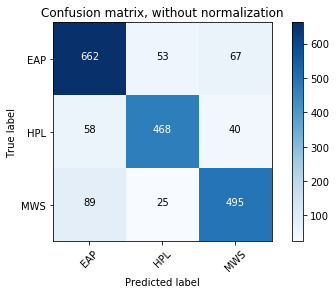

In [18]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_label[val_idx], np.argmax(y_pred, axis = 1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')

plt.show()

Let's add the predicted probabilities to train/test set.

In [19]:
# Add the probabilities to features of train set
train['lstm_EAP'] = train_pred[:, 0]
train['lstm_HPL'] = train_pred[:, 1]
train['lstm_MWS'] = train_pred[:, 2]

In [20]:
model = lstm_nn(num_words, max_len)
model.fit(x = train_text, y = y, batch_size = 32, epochs = 10, verbose = 0)
test_pred = model.predict(test_text)

# Add the probabilities to features of test set
test['lstm_EAP'] = test_pred[:, 0]
test['lstm_HPL'] = test_pred[:, 1]
test['lstm_MWS'] = test_pred[:, 2]

Sentence to Vectors
--------------

Instead of introducing embeddings for words, we could also try to convert the entire sentences to a vector, and make predictions based on the sentence vector. This time, we will use GloVe word embeddings, which contain 400,000 word vectors, each with a dimensionality of 100.

In [21]:
word_embeddings = {}
with open('glove.6B.100d.txt', 'r') as f:
    for line in f:
        tokens = line.split()
        word = tokens[0]
        values = np.asarray(tokens[1:], dtype = 'float32')
        word_embeddings[word] = values

print('GloVe word vectors length: ', len(word_embeddings))

GloVe word vectors length:  400000


Then let's turn each sentence into a normalized vector by using the word embeddings we just loaded.

In [22]:
def sent2vec(sent, word_embeddings):
    words = word_tokenize(str(sent).lower())
    words = list(filter(lambda w: not w in stopwords.words('english'), words)) # Filter out stop words
    words = list(filter(lambda w: w.isalpha(), words)) # Remove punctuations, numbers etc.
    embedding = [word_embeddings[w] for w in words if w in word_embeddings] # Look up the embedding for each word
    embedding = np.array(embedding)
    s = np.sum(embedding, axis = 0)
    if type(s) != np.ndarray:
        return np.zeros(100)
    return s / np.sqrt(np.sum(s ** 2)) # Normalize the sentence vector

In [23]:
# Convert each sentence to vector
train_glove_vec = [sent2vec(sent, word_embeddings) for sent in train['text']]
train_glove_vec = np.array(train_glove_vec)
test_glove_vec = [sent2vec(sent, word_embeddings) for sent in test['text']]
test_glove_vec = np.array(test_glove_vec)
print('Train sentence vector size: ', train_glove_vec.shape)
print('Test sentence vector size: ', test_glove_vec.shape)

Train sentence vector size:  (19579, 100)
Test sentence vector size:  (8392, 100)


Now let's train a 3-layer neural network model using the sentence vectors.

In [24]:
# Architecture of 3-layer neural network
def glove_nn():
    model = Sequential()
    # Input layer
    model.add(Dense(128, input_dim = 100, activation = 'relu'))
    model.add(BatchNormalization())
    # Second layer
    model.add(Dense(128, activation = 'relu'))
    model.add(BatchNormalization())
    # Output layer
    model.add(Dense(3, activation = 'softmax'))
    # Compile the model
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
    return model

In [25]:
# Scale the input data before feeding it into neural network
scaler = StandardScaler()
train_glove_vec = scaler.fit_transform(train_glove_vec)
test_glove_vec = scaler.transform(test_glove_vec)
y = np_utils.to_categorical(y_label)

# Run a 10-fold cross-validation using train sentence vector
log_loss = []
train_pred = np.zeros([train_glove_vec.shape[0], 3])
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for dev_idx, val_idx in kf.split(train):
    X_dev, X_val = train_glove_vec[dev_idx], train_glove_vec[val_idx]
    y_dev, y_val = y[dev_idx], y[val_idx]
    model = glove_nn()
    model.fit(x = X_dev, y = y_dev, batch_size = 32, epochs = 10, verbose = 0, validation_data = (X_val, y_val))
    y_pred = model.predict(X_val)
    log_loss.append(metrics.log_loss(y_val, y_pred))
    train_pred[val_idx] = y_pred # The predicted probabilities for validation set 

print("Mean cross-validation log-loss", np.mean(log_loss))

Mean cross-validation log-loss 0.911168090601


The log-loss is 0.91, not as good as what we achieved in Notebook 2. Let's plot the confusion matrix.

Confusion matrix, without normalization
[[542 102 138]
 [151 315 100]
 [127  81 401]]


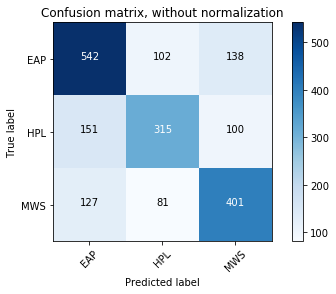

In [26]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_label[val_idx], np.argmax(y_pred, axis = 1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')

plt.show()

Then let's add the predicted probabilities to train/test set as new features.

In [27]:
# Add the probabilities to features of train set
train['glove_EAP'] = train_pred[:, 0]
train['glove_HPL'] = train_pred[:, 1]
train['glove_MWS'] = train_pred[:, 2]

In [28]:
model = glove_nn()
model.fit(x = train_glove_vec, y = y, batch_size = 32, epochs = 10, verbose = 0)
test_pred = model.predict(test_glove_vec)

# Add the probabilities to features of test set
# Test is wrong
test['glove_EAP'] = test_pred[:, 0]
test['glove_HPL'] = test_pred[:, 1]
test['glove_MWS'] = test_pred[:, 2]

FastText
--------------

We will also try Facebook FastText model. We will use 1~3grams as features, and preprocess the text as we did for 1D CNN, including:

- Separate punctuations from words
- Remove rare terms which appear only once
- Cut long sentence which contains more than 256 terms

Here terms refer to unigram, bigram and trigram. The architecture of FastText includes:

- Input layer: ngram features are fed into the neural network
- Hidden layer: features are embedded and averaged
- Ouput layer: softmax

In [29]:
# Create ngrams
def ngram(doc, n = 3):
    ngrams = []
    for i in range(2, n + 1):
        for j in range(len(doc) - i + 1):
            ngrams.append('--'.join(doc[j:j+i]))
    return doc + ngrams

In [30]:
# Turn each sentence into sequence of unigram, bigram, ..., ngram
def create_doc(data, n = 3):
    docs = []
    for text in data:
        doc = sep_punctuation(text).split()
        docs.append(' '.join(ngram(doc, n)))
    return docs

In [31]:
all_docs = create_doc(train['text'].values.tolist() + test['text'].values.tolist())
train_docs = create_doc(train['text'].values.tolist())
test_docs = create_doc(test['text'].values.tolist())

tokenizer = Tokenizer(filters = '') # Treat punctuations as words
tokenizer.fit_on_texts(all_docs)
num_terms = sum([1 for _, v in tokenizer.word_counts.items() if v >= 2]) # remove rare terms

tokenizer = Tokenizer(num_words = num_terms, filters = '')
tokenizer.fit_on_texts(all_docs)
train_docs = tokenizer.texts_to_sequences(train_docs)
test_docs = tokenizer.texts_to_sequences(test_docs)

print('Number of unique terms: ', num_terms)

Number of unique terms:  169966


In [32]:
max_len = 256

train_docs = pad_sequences(train_docs, maxlen = max_len)
test_docs = pad_sequences(test_docs, maxlen = max_len)

In [33]:
# Architecture of FastText
def fast_text(input_dim):
    model = Sequential()
    # Embeddings, using a dimensionality of 100
    model.add(Embedding(input_dim, 100))
    # Embeddings are averaged
    model.add(GlobalAveragePooling1D())
    # Ouput layer
    model.add(Dense(3, activation = 'softmax'))
    # Compile the model
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')
    return model

In [34]:
input_dim = max(np.max(train_docs), np.max(test_docs)) + 1 # Largest index of terms
y = np_utils.to_categorical(y_label)

# Run a 10-fold cross-validation using ngram features
log_loss = []
train_pred = np.zeros([train_docs.shape[0], 3])
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for dev_idx, val_idx in kf.split(train):
    X_dev, X_val = train_docs[dev_idx], train_docs[val_idx]
    y_dev, y_val = y[dev_idx], y[val_idx]
    model = fast_text(input_dim)
    model.fit(x = X_dev, y = y_dev, batch_size = 32, epochs = 20, verbose = 0, 
              validation_data = (X_val, y_val), callbacks = [earlyStopping])
    y_pred = model.predict(X_val)
    log_loss.append(metrics.log_loss(y_val, y_pred))
    train_pred[val_idx] = y_pred # The predicted probabilities for validation set 

print("Mean cross-validation log-loss", np.mean(log_loss))

Mean cross-validation log-loss 0.345616391037


The log-loss is only 0.35, the lowest so far! Let's plot the confusion matrix.

Confusion matrix, without normalization
[[643  55  84]
 [ 42 485  39]
 [ 44  28 537]]


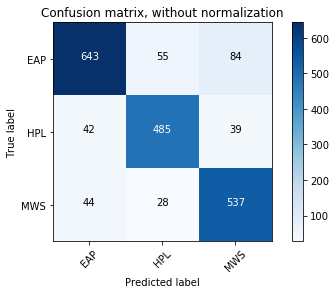

In [35]:
# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_label[val_idx], np.argmax(y_pred, axis = 1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')

plt.show()

In [36]:
# Add the probabilities to features of train set
train['fast_EAP'] = train_pred[:, 0]
train['fast_HPL'] = train_pred[:, 1]
train['fast_MWS'] = train_pred[:, 2]

In [37]:
model = fast_text(input_dim)
model.fit(x = train_docs, y = y, batch_size = 32, epochs = 10, verbose = 0)
test_pred = model.predict(test_docs)
# Add the probabilities to features of test set
test['fast_EAP'] = test_pred[:, 0]
test['fast_HPL'] = test_pred[:, 1]
test['fast_MWS'] = test_pred[:, 2]

Model with Combined Features
------------

Now let's combine all the features we have created so far and train a xgboost model on them.

In [38]:
def run_xgboost(X_train, y_train, X_val):
    param = {'silent': 1, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.8, 'colsample_bytree': 0.5,
             'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'num_class': 3, 'seed': 1001}
    plst = param.items()
    num_round = 1000
    dtrain = xgb.DMatrix(X_train, label = y_train)
    model = xgb.train(plst, dtrain, num_round)
    dtest = xgb.DMatrix(X_val)
    y_pred = model.predict(dtest, ntree_limit = model.best_ntree_limit)
    return model, y_pred

In [39]:
# Features
X = train.drop(['id', 'text', 'author'], axis = 1)
X.shape

(19579, 234)

In [40]:
# Run a 10-fold cross-validation using train set
log_loss = []
kf = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 1001)
for dev_idx, val_idx in kf.split(X):
    X_dev, X_val = X.iloc[dev_idx], X.iloc[val_idx]
    y_dev, y_val = y_label[dev_idx], y_label[val_idx]
    model, y_pred = run_xgboost(X_dev, y_dev, X_val)
    log_loss.append(metrics.log_loss(y_val, y_pred))

print("Mean cross-validation log-loss", np.mean(log_loss))

Mean cross-validation log-loss 0.304155932054


The log-loss is only 0.30 now! Let's fit XGBoost model using all the train data and predict the authors for the test set.

In [41]:
# Features of test set
X_test = test.drop(['id', 'text'], axis = 1)
X_test.shape

(8392, 234)

In [43]:
model, test_prob = run_xgboost(X, y_label, X_test)
sub_id = test['id'].values.reshape((len(test['id']), 1))
submission = np.concatenate((sub_id, test_prob), axis = 1)
submission = pd.DataFrame(submission, columns = ['id', 'EAP', 'HPL', 'MWS'])
submission.head()

,id,EAP,HPL,MWS
0,id02310,0.0112683,0.00109443,0.987637
1,id24541,0.999285,0.000122546,0.000592818
2,id00134,0.000899481,0.998933,0.000167503
3,id27757,0.814295,0.183872,0.00183239
4,id04081,0.966587,0.030437,0.00297595


In [44]:
submission.to_csv('submission.csv')

The final score is 0.31374 on Kaggle.

Reference
---------

[1] https://www.kaggle.com/rtatman/glove-global-vectors-for-word-representation/data

[2] https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/